In [15]:
# If running in Colab, uncomment the install line
# !pip install pybaseball pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast
from pybaseball import cache
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Enable caching to speed up repeated Statcast queries
cache.enable()

# Optional: suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Set plotting style
sns.set(style="whitegrid")


In [16]:
# Define the date range
start_date = '2025-03-30'
end_date = '2025-04-06'

print("Fetching Statcast data...")
df = statcast(start_dt=start_date, end_dt=end_date)
print(f"Data fetched: {df.shape[0]} rows, {df.shape[1]} columns")


Fetching Statcast data...
This is a large query, it may take a moment to complete


100%|████████████████████████████████| 8/8 [00:02<00:00,  3.33it/s]

Data fetched: 30279 rows, 118 columns


In [17]:
# Preview the first few rows
df.head()


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
3834,FF,2025-04-06,95.4,-1.82,5.62,"Fernandez, Ryan",677800,681676,single,hit_into_play,...,0,1.02,0.68,-0.68,59.1,7.80283,13.702551,23.622675,41.433457,24.973435
3979,FF,2025-04-06,94.7,-1.77,5.66,"Fernandez, Ryan",596115,681676,field_out,hit_into_play,...,0,1.17,0.7,0.7,56.6,3.454014,0.894664,23.598478,28.970423,29.394897
4108,FF,2025-04-06,95.0,-1.79,5.71,"Fernandez, Ryan",596115,681676,NaN,ball,...,0,1.24,0.76,0.76,57.9,<NA>,<NA>,<NA>,<NA>,<NA>
4253,SL,2025-04-06,85.0,-2.02,5.64,"Fernandez, Ryan",596115,681676,NaN,foul,...,0,3.22,-0.25,-0.25,54.1,17.628286,-9.611324,30.742102,37.085465,44.914698
4403,SL,2025-04-06,84.5,-1.96,5.58,"Fernandez, Ryan",596115,681676,NaN,ball,...,0,3.16,-0.36,-0.36,63.0,<NA>,<NA>,<NA>,<NA>,<NA>


In [18]:
# Keep only rows with relevant metrics for modeling wOBA
df_clean = df.dropna(subset=["launch_speed", "launch_angle", "woba_value"])
print(f"Filtered data: {df_clean.shape[0]} rows remaining")

# Optional: check data types
df_clean.dtypes


Filtered data: 5186 rows remaining


pitch_type                                          object
game_date                                   datetime64[ns]
release_speed                                      Float64
release_pos_x                                      Float64
release_pos_z                                      Float64
                                                 ...      
attack_angle                                       Float64
attack_direction                                   Float64
swing_path_tilt                                    Float64
intercept_ball_minus_batter_pos_x_inches           Float64
intercept_ball_minus_batter_pos_y_inches           Float64
Length: 118, dtype: object

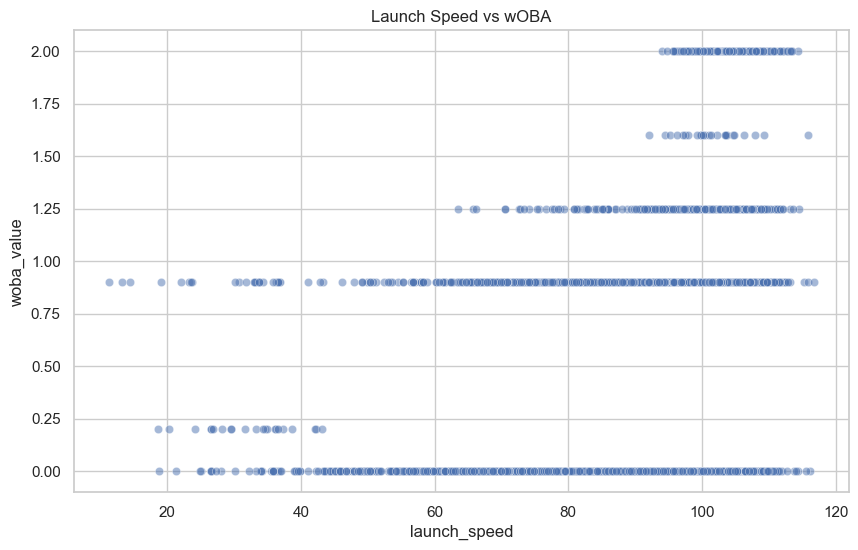

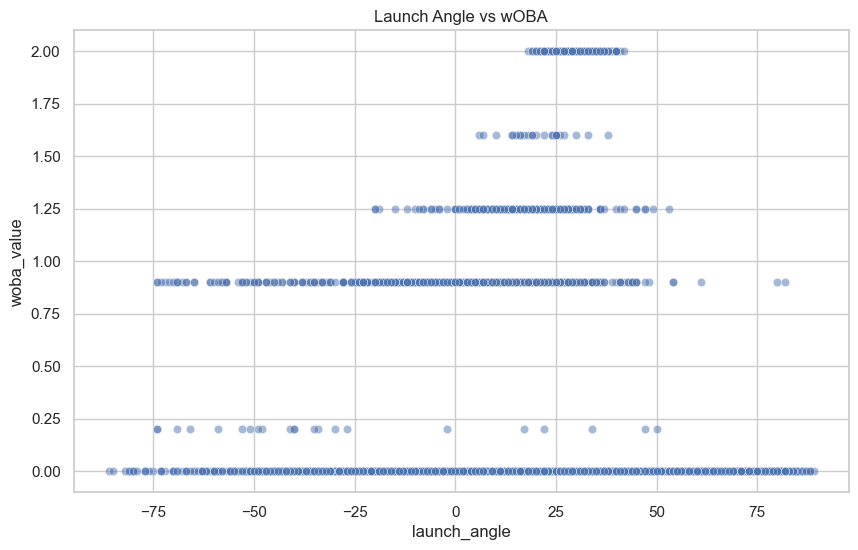

In [19]:
# Simple scatter plot to see relationship between launch speed/angle and wOBA
plt.figure(figsize=(10,6))
sns.scatterplot(x='launch_speed', y='woba_value', data=df_clean, alpha=0.5)
plt.title("Launch Speed vs wOBA")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='launch_angle', y='woba_value', data=df_clean, alpha=0.5)
plt.title("Launch Angle vs wOBA")
plt.show()


In [20]:
# Features (X) and target (y)
X = df_clean[["launch_speed", "launch_angle"]]
y = df_clean["woba_value"]

# Quick check
X.head(), y.head()


(      launch_speed  launch_angle
 3834          98.1            28
 3979          62.9            56
 2653          94.6            39
 2426          87.2            23
 2786         105.8            16,
 3834     0.9
 3979     0.0
 2653     0.0
 2426    1.25
 2786     0.0
 Name: woba_value, dtype: Float64)

In [21]:
# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} rows")
print(f"Testing set: {X_test.shape[0]} rows")


Training set: 4148 rows
Testing set: 1038 rows


In [22]:
# Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Check coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Coefficients: [ 0.01008921 -0.00063865]
Intercept: -0.5122324280072572


Mean Squared Error: 0.3068
R^2 Score: 0.0814


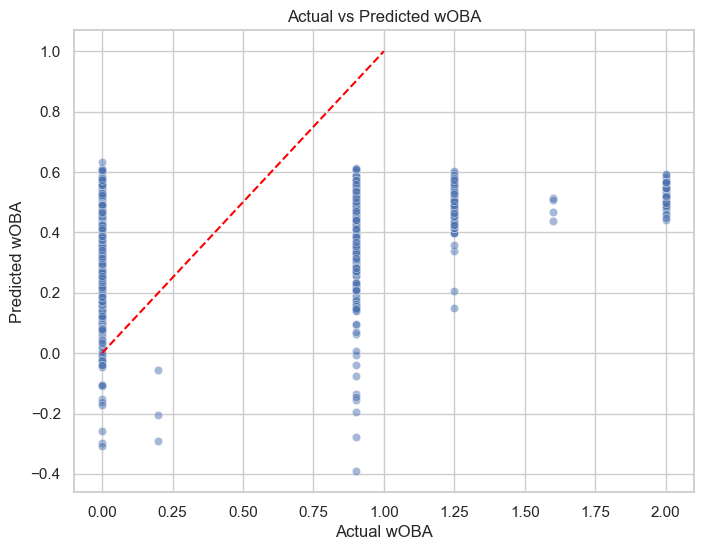

In [23]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual wOBA")
plt.ylabel("Predicted wOBA")
plt.title("Actual vs Predicted wOBA")
plt.plot([0,1],[0,1], color='red', linestyle='--')  # 45-degree reference line
plt.show()
